# Codes Book 2

The code in this notebook are relating to EDA and Data prepration for Modeling

## Import Library

In [1]:
import numpy as np
import pandas as pd

# Library for importing data and storing large dataset
import glob
import gc
import h5py

# Import package
from wordcloud import WordCloud, STOPWORDS

# Modeling
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import pairwise_distances, cosine_distances, cosine_similarity
from sklearn.neighbors import NearestNeighbors
from keras.layers import Input, Embedding, Dot, Reshape, Dense
from keras.models import Model
from tensorflow.keras.utils import plot_model

# For dealing with iterables
from itertools import chain
from collections import ChainMap

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# API Call
import requests

from datetime import datetime
import time
import random
import ast

# Additional Setting
pd.set_option("display.max_rows", 200)


## User Defined Functions

In [2]:
# Time function

def t_now(string):
    '''
    Insert Docstring
    '''
    time = datetime.now()
    current_time = time.strftime("%H:%M:%S")
    return f"{string} = {current_time}"

In [3]:
# Mean Centering

def mean_center_rows(df):
    '''
    Function to center a dataset based on mean
    
    arg1 (df): Dataframe
    '''
    return (df.T - df.mean(axis=1)).T

In [4]:
def common_scale(val, new_range, pd_series):
    '''
    Function will scale element of pandas series to new range
    
    arg1 (int)    : value
    arg2 (list)  : [Min, Max]
    arg3 (series) : Pandas series to apply function to
    
    Return: the new scaled valued
    '''
    s_range = [pd_series.min(),pd_series.max()]
    return round(np.diff(new_range)[0] * ((val - s_range[0])/(np.diff(s_range)[0])) + 1,2)

## Import of Data

### Importing Movie Rating File by users

In [5]:
# Check hdf5 for rating file
hf = h5py.File('datasets/movie_raw.hdf5','r')
print(f'Dataframe in movie.hdf5 file {hf.keys()}')
hf.close()

# Import user rating file
with pd.HDFStore('datasets/movie_raw.hdf5') as store:
    ratings = store['full_ratings']

Dataframe in movie.hdf5 file <KeysViewHDF5 ['full_ratings', 'titles_cleaned', 'titles_search_mvid']>


In [6]:
# Check the shape of the dataframe
ratings.shape

(93140230, 4)

In [7]:
# Check the data type of user ratings
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93140230 entries, 0 to 100480506
Data columns (total 4 columns):
 #   Column       Dtype         
---  ------       -----         
 0   customer_id  int32         
 1   rating       int8          
 2   date         datetime64[ns]
 3   movie_id     int16         
dtypes: datetime64[ns](1), int16(1), int32(1), int8(1)
memory usage: 2.0 GB


In [8]:
ratings.head()

,customer_id,rating,date,movie_id
0,1488844,3,2005-09-06,1
1,822109,5,2005-05-13,1
2,885013,4,2005-10-19,1
3,30878,4,2005-12-26,1
4,823519,3,2004-05-03,1


### EDA - User Ratings

In [9]:
# Check the number of ratings by titles.
ratingsbymovie = pd.DataFrame(ratings.groupby('movie_id')['customer_id'].count())
ratingsbymovie.rename(columns={'customer_id':'cust_id_count'},inplace=True)
ratingsbymovie.head()

,cust_id_count
movie_id,
1,547
3,2012
4,142
6,1019
7,93


In [10]:
# Check Statistic Summary
np.round(ratingsbymovie.describe())

,cust_id_count
count,14923.0
mean,6241.0
std,17912.0
min,3.0
25%,203.0
50%,635.0
75%,3056.0
max,232944.0


### When Have The Movie Been Rated?

Text(0.5, 0, 'Date')

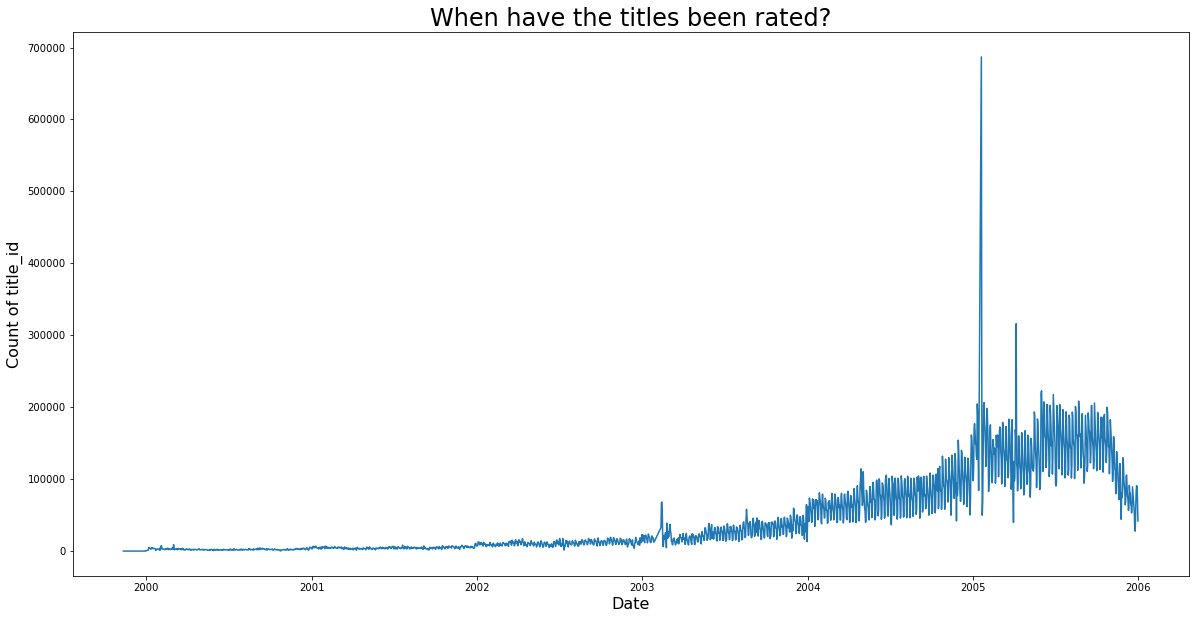

In [11]:
figure, axes = plt.subplots(figsize=(20,10))
sns.lineplot(data=ratings.groupby('date')['movie_id'].count())

# Additional Setting
axes.set_title('When have the titles been rated?', fontsize=24)
axes.set_ylabel('Count of title_id', fontsize=16)
axes.set_xlabel('Date', fontsize=16)

<span style= 'color:magenta'>Remark:</span>
There is an increase in number of ratings from 2003 onwards, probably due to the increasingly popularity of Netflix as well as the number of titles available in Netflix. We note that there was a high spike at the start of 2005. This is likely due: 
 - A surge in subscribers from 2.1M to 6.3M during the year.
 - A launch of Netflix Prize for recommender system which serve as product awareness marketing efforts that result in people more studious in rating what they watch.
 
The trend dwindle nearer to 2006 may be due to the fact that people as the rating the titles before they send back the rented DVDs may not be a novel experience anymore and it become more of a hassel to do so especially if they rented a few titles at one go.

Supporting document:

<a href="https://interestingengineering.com/the-fascinating-history-of-netflix">History of Netflix</a> <br>
<a href="https://en.wikipedia.org/wiki/Timeline_of_Netflix">Timeline of Netflix</a>

### How are the Rating Distributed

In [12]:
print(ratings['rating'].value_counts(normalize=True).sort_index(ascending=False))
print('\n')
print(ratings['rating'].value_counts().sort_index(ascending=False))

ratings_pct = list(ratings['rating'].value_counts(normalize=True).sort_index(ascending=False))
ratings_score = list(ratings['rating'].value_counts().sort_index(ascending=False))

5    0.227456
4    0.336807
3    0.288572
2    0.101522
1    0.045643
Name: rating, dtype: float64


5    21185291
4    31370246
3    26877648
2     9455805
1     4251240
Name: rating, dtype: int64


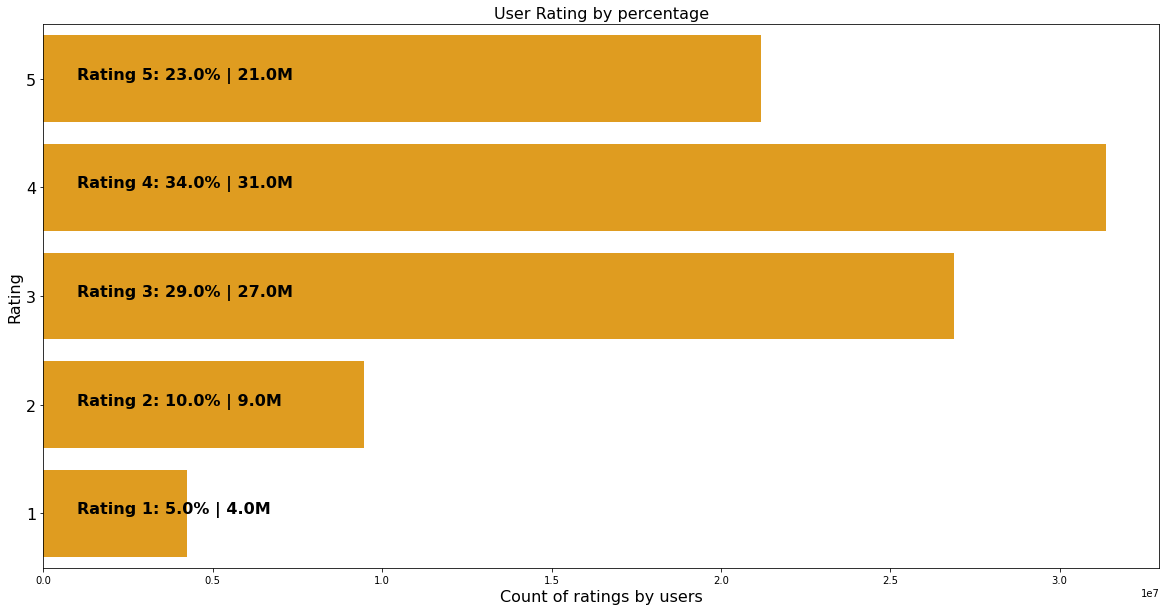

In [13]:
fig , axes = plt.subplots(figsize=(20,10))
sns.countplot(y='rating', data=ratings, color='orange', order=[5,4,3,2,1], ax=axes)

axes.set_title('User Rating by percentage', fontsize=16)
axes.set_ylabel('Rating', fontsize=16)
axes.set_yticklabels(axes.get_yticklabels(), fontsize=16)
#axes.set_xticklabels (axes.get_xticklabels(), fontsize=16)
axes.set_xlabel('Count of ratings by users', fontsize=16)

# Create point labels
for i in range(5):
    axes.text(0.1*10**7, i, f"Rating {5-i}: {np.round(ratings_pct[i]*100)}% | {np.round(ratings_score[i]/1_000_000)}M", weight='bold', fontsize=16)

<span style= 'color:magenta'>Remark:</span>
Looing at the distribution of the rating, we see that most of the ratings are 3 and above. This make sense as users generally would not waste effort to rate a title that negatively unless the titles are really unacceptable that they feel the need to be 'civil' to warn others.

count    480098.0
mean        194.0
std         276.0
min           1.0
25%          36.0
50%          90.0
75%         241.0
max       14816.0
Name: rating, dtype: float64


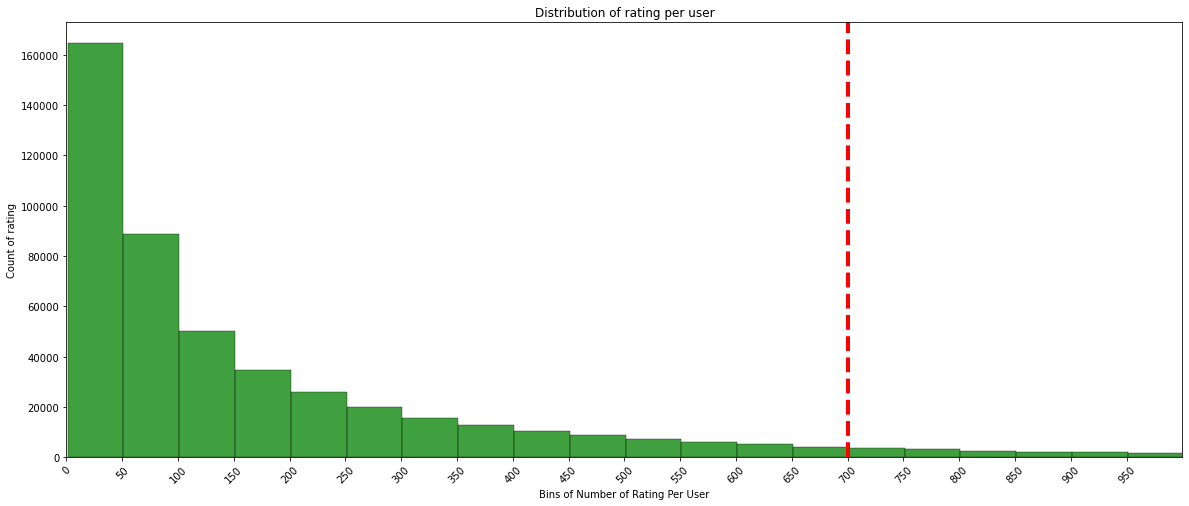

In [14]:
# Create a histogram of the ratings per movie

data = ratings.groupby('customer_id')['rating'].count()

print(np.round(data.describe()))

fig, axes = plt.subplots(figsize=(20,8))
sns.histplot(data=data, binwidth = 50, ax=axes, color='green')
axes.set_xlim(0,1000)
axes.set_xlabel('Bins of Number of Rating Per User')
axes.set_ylabel('Count of rating')
axes.set_title('Distribution of rating per user')
plt.xticks(range(0, 1000, 50), rotation=45);
#axes.axhline(5000, linewidth=4, linestyle = '--', color='r')
axes.axvline(700, linewidth=4, linestyle = '--', color='r')

<span style= 'color:magenta'>Remark:</span>
Per my expectation that the histogram is a decaying curve as less & less users will spend the effort to rate all the movie that they watch. The peak rating per users is at 30. Although the distribution is left-skewed, I will be keeping users who are active in contributing to the ratings rather than users who are inactive. The rationale is that users who are active will tends to rate most of the titles they watch. In another word, I can keep my dataset smaller (rows = user's ratings) without losing too much rating information.  
> Due to limited computation resources. I am unable to work on the entire set of the given data. As such, I will only keep users that have contributed more than 700 ratings. This should provide me with good enough dataset for modeling. 

count     14923.0
mean       6241.0
std       17912.0
min           3.0
25%         203.0
50%         635.0
75%        3056.0
max      232944.0
Name: rating, dtype: float64


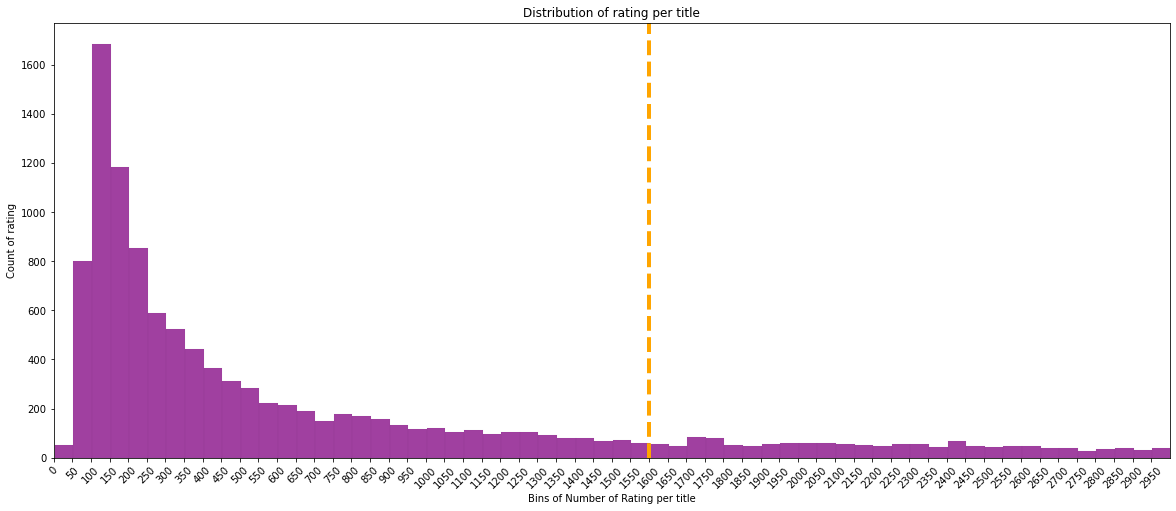

In [15]:
# Create a histogram of the ratings per movie

data = ratings.groupby('movie_id')['rating'].count()

print(np.round(data.describe()))

fig, axes = plt.subplots(figsize=(20,8))
sns.histplot(data=data, binwidth = 50, ax=axes, color='purple')
axes.set_xlim(0,3000)
axes.set_xlabel('Bins of Number of Rating per title')
axes.set_ylabel('Count of rating')
axes.set_title('Distribution of rating per title')
plt.xticks(range(0, 3000, 50), rotation=45);
#axes.axhline(100, linewidth=4, linestyle = '--', color='orange')
axes.axvline(1600, linewidth=4, linestyle = '--', color='orange')

<span style= 'color:magenta'>Remark:</span>
Looking at the histogram, Most titles have around 100-150 ratings. We do see a decay curve which we expected as it is quite difficult for titles to garner more ratings. The titles have to be either exceptionally good or bad for people to comment on them. There is a small number of titles which have 0-50 ratings. They could be new titles where most of the users have not watched or they are unimpressive for users to rate them.

> Due to limited computational resources. I am unable to work on the entire set of the given data. As such, I will only keep titles which have at most 1600 ratings. This should give me a smaller dataset while keeping rating information lost to the miminum.

### Subsetting of Ratings for Modeling

In [16]:
# Create a copy of the ratings dataframe
users = ratings.copy()

#### Filtering of customer_id based on ratings per customer

In [17]:
# Find the ratings contributed per user
data = ratings.groupby('customer_id')['rating'].count()

# Filter users based on total ratings contributed
data = data[data >=700]

# Create a list of retained users
retained_list = list(data.index)

print(f'Number of users retained: {len(data)}')
data.head()

Number of users retained: 25510


customer_id
7        813
79       748
769     1036
1310     748
1333    2710
Name: rating, dtype: int64

In [18]:
# Filter users dataframe
users = users[ratings['customer_id'].isin(retained_list)]
print(users.shape)

(27034652, 4)


#### Filtering of titles based on ratings per titles

In [19]:
# Find the rating per title
data = ratings.groupby('movie_id')['rating'].count()

# Filter data
data = data[data >=1600]

# Create a list of retained titles
retain_list = list(data.index)

print(f'Number of titles retained: {len(data)}')
data.head()

Number of titles retained: 5198


movie_id
3      2012
16     2699
17     7108
18    10722
26     5861
Name: rating, dtype: int64

In [20]:
# Filter users dataframe
users = users[ratings['movie_id'].isin(retain_list)]
print(users.shape)

<ipython-input-20-8fa98d698750>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  users = users[ratings['movie_id'].isin(retain_list)]


(25304927, 4)


In [21]:
# Check number of unique titles retained
print(users['movie_id'].nunique())

5198


In [22]:
# # saving subset titles to movie file
save_hdf5 = pd.HDFStore('datasets/movie.hdf5')
save_hdf5['subset_title_ids'] = pd.Series(users['movie_id'].unique())
save_hdf5.close()

In [23]:
# Memory management
del ratings
gc.collect()

0

### Importing Title File

In [24]:
# Check hdf5 for rating file
hf = h5py.File('datasets/movie_raw.hdf5','r')
print(f'Dataframe in movie.hdf5 file {hf.keys()}')
hf.close()

# Import user rating file
with pd.HDFStore('datasets/movie_raw.hdf5') as store:
    titles = store['titles_cleaned']

Dataframe in movie.hdf5 file <KeysViewHDF5 ['full_ratings', 'titles_cleaned', 'titles_search_mvid']>


In [25]:
print(f'Shape of title dataframe {titles.shape}')
titles.head()

Shape of title dataframe (14923, 10)


,movie_id,year_of_release,title,type,featured_actor,keywords,genre,popularity,vote_count,vote_average
0,7003,2005.0,national geographic: arlington: field of honor,movie,Zahi Hawass,"[egypt, museum, mummy, excavation, ancient egy...","[Documentary, History, TV Movie]",4.338,2.0,7.0
1,9603,2005.0,pink floyd: atom heart mother,movie,Roger Waters,"[biography, classic rock]",[Documentary],1.863,1.0,7.0
2,14762,2005.0,devour,movie,Jensen Ackles,"[video game, tattoo, nightmare, daydream, murd...",[Horror],8.569,53.0,5.1
3,14757,2005.0,palindromes,movie,Ellen Barkin,"[teenage pregnancy, runaway teen]","[Comedy, Drama]",12.121,102.0,6.2
4,631,2005.0,unleashed,movie,Jet Li,"[martial arts, hitman, serial killer]","[Action, Crime]",17.592,1225.0,6.8


### EDA - Titles

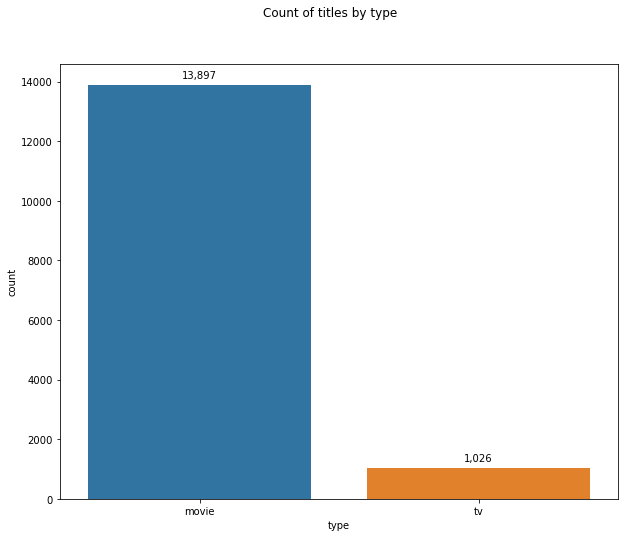

In [26]:
plt.figure(figsize=(10, 8))
splot = sns.countplot(x='type', data=titles)
plt.suptitle('Count of titles by type')
for p in splot.patches:
    splot.annotate(format(p.get_height(),","), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

<span style= 'color:magenta'>Remark:</span>
From the chart, we do expect that there will be more movies compared to Mini-series. This will not be an issue to as our main objective is to push relevant titles to users.

#### Genre Analysis

In [27]:
genre_popularity = titles[['type','genre']].explode('genre')
gp = genre_popularity['genre'].value_counts().sort_values(ascending=False)

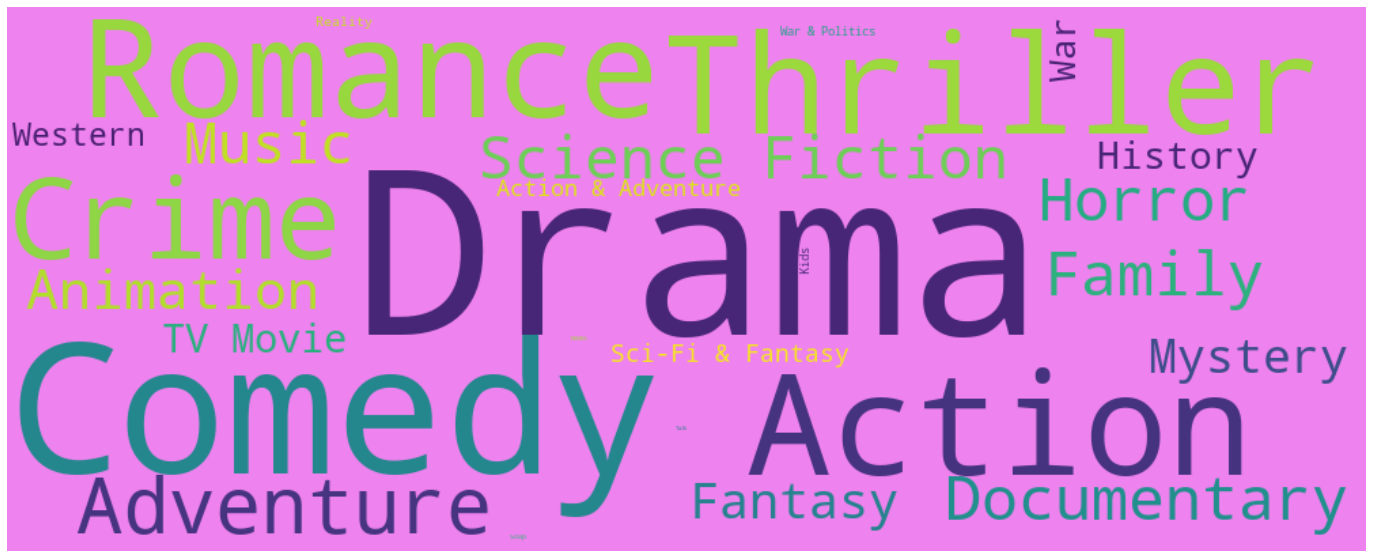

In [28]:
genre_wc = WordCloud(width=1000,height=400,background_color='violet')
genre_wc.generate_from_frequencies(gp.to_dict())
plt.figure(figsize=(30, 10))
plt.imshow(genre_wc, interpolation="bilinear")
plt.axis('off');

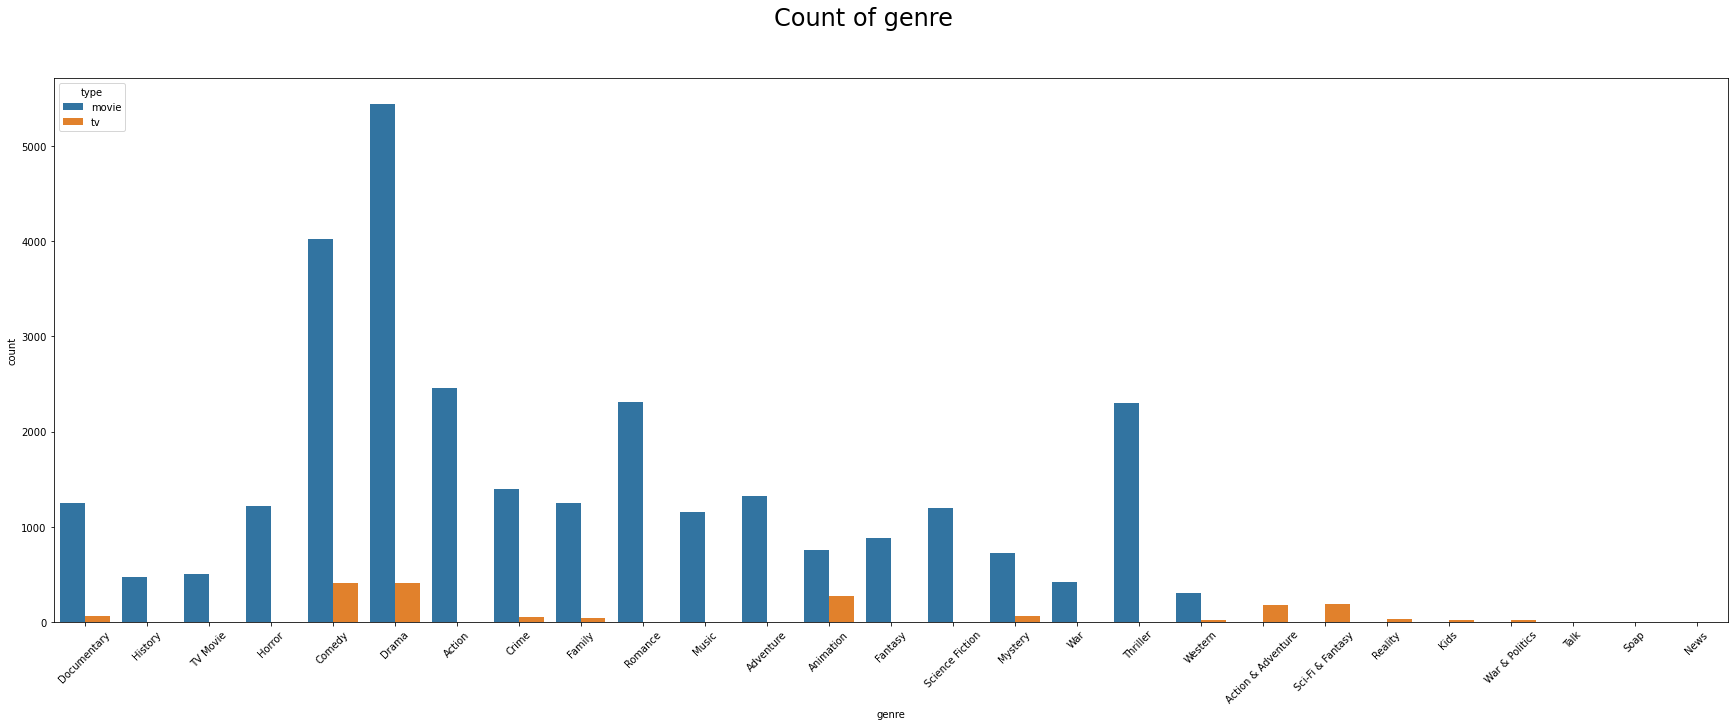

In [29]:
plt.figure(figsize=(30,10))
sbplots = sns.countplot(x = 'genre', data=genre_popularity, hue='type')
plt.suptitle('Count of genre', fontsize=24)
plt.xticks(rotation=45);

<span style= 'color:magenta'>Remark:</span>
From the chart, We see that the most common genre for movies are Drame, Comedy, action, romance & thriller. For Mini-Series, they are comedy, Drama and Animation. 
The choice of genre for 2 different type are expected due to the number of movies/mini-series that comes out each year.

#### Keywords Analysis

In [30]:
kw_popularity = titles[['type','keywords']].explode('keywords')
kw = kw_popularity['keywords'].value_counts().sort_values(ascending=False)

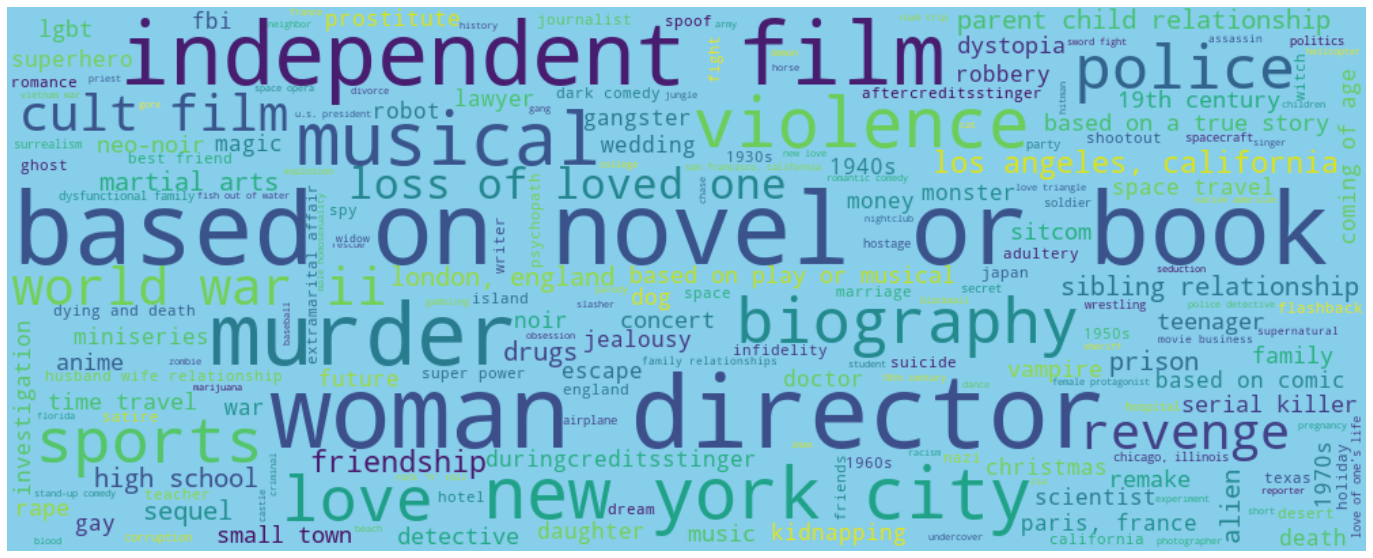

In [31]:
kw_wc = WordCloud(width=1000,height=400,background_color='skyblue')
kw_wc.generate_from_frequencies(kw.to_dict())
plt.figure(figsize=(30, 10))
plt.imshow(kw_wc, interpolation="bilinear")
plt.axis('off');

In [32]:
kw_popularity['keywords'].value_counts().sort_values(ascending=False).head(20)

based on novel or book       656
woman director               649
independent film             474
murder                       461
musical                      322
new york city                314
violence                     298
love                         235
biography                    231
sports                       226
police                       217
world war ii                 212
cult film                    205
revenge                      201
loss of loved one            192
los angeles, california      188
friendship                   182
parent child relationship    179
alien                        173
sibling relationship         170
Name: keywords, dtype: int64

<span style= 'color:magenta'>Remark:</span>
Based on the keywords, it seems like most of the titles are based on novel or book and are surprisingly directed by female directors. In addition, most of the films are independent film, this is quite expected as Netflix targets independent films as they are cost efficient and less restriction compared to agency's films.

#### Featured Actors/Actress

In [33]:
fa_popularity = titles[['type','featured_actor']].explode('featured_actor')
fa = fa_popularity['featured_actor'].value_counts().sort_values(ascending=False)

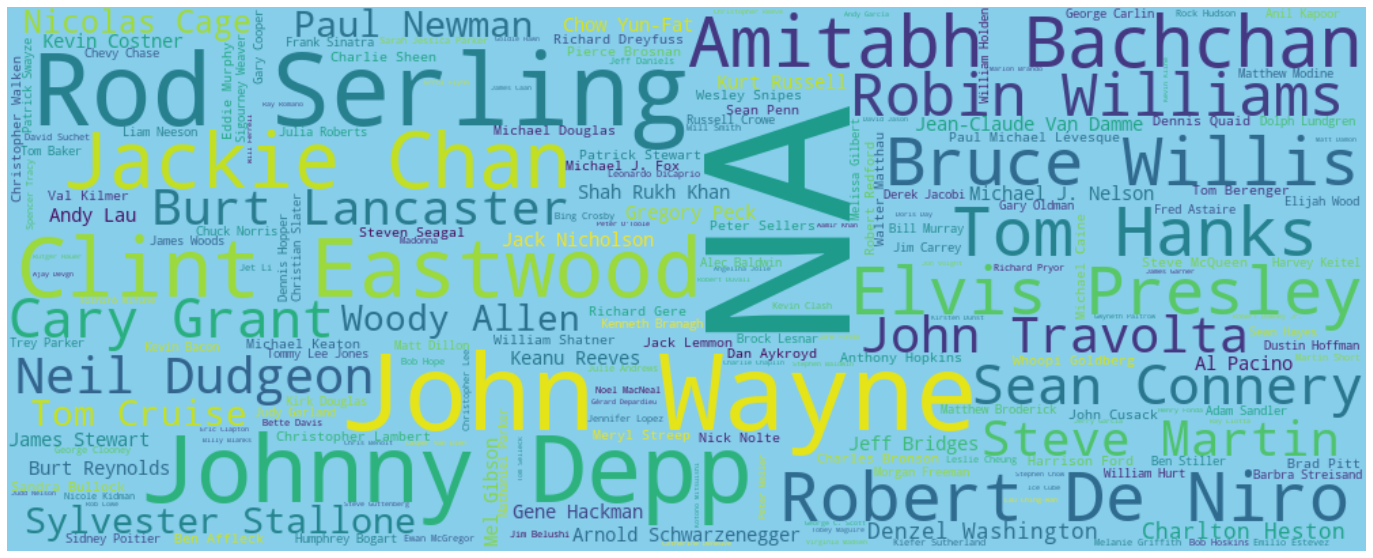

In [34]:
fa_wc = WordCloud(width=1000,height=400,background_color='skyblue')
fa_wc.generate_from_frequencies(fa.to_dict())
plt.figure(figsize=(30, 10))
plt.imshow(fa_wc, interpolation="bilinear")
plt.axis('off');

In [35]:
fa.head(20)

NA                    1167
John Wayne              50
Rod Serling             45
Johnny Depp             39
Clint Eastwood          38
Jackie Chan             34
Amitabh Bachchan        33
Robert De Niro          31
Tom Hanks               31
Bruce Willis            30
Elvis Presley           30
Robin Williams          29
Sean Connery            29
Cary Grant              29
John Travolta           28
Neil Dudgeon            28
Burt Lancaster          28
Steve Martin            28
Sylvester Stallone      26
Paul Newman             26
Name: featured_actor, dtype: int64

<span style= 'color:magenta'>Remark:</span>
From the analysis, most of the titles do not have a designated featured actor/actress in the MovieDB. As such, I will not be using featured_actor in my analysis.

## Recommendation Modelings Preps

### Data prep for Collaborative Filtering

In [36]:
# Reset index of users dataframe
users.reset_index(drop=True, inplace=True)
users.head()

,customer_id,rating,date,movie_id
0,712664,5,2004-02-01,3
1,1331154,4,2004-07-03,3
2,1644750,3,2003-03-19,3
3,701730,2,2005-10-05,3
4,1614320,4,2003-08-11,3


In [37]:
# drop columns
users.drop(columns=['date'], inplace=True)
users.head()

,customer_id,rating,movie_id
0,712664,5,3
1,1331154,4,3
2,1644750,3,3
3,701730,2,3
4,1614320,4,3


#### Create User-Titles Matrix

In [38]:
# create utility matrix and covert datatype
users = users.pivot_table(index='customer_id', columns='movie_id', values='rating').apply(pd.to_numeric, args=('coerce','float'))
print(users.info())
users.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25510 entries, 7 to 2649296
Columns: 5198 entries, 3 to 17769
dtypes: float32(5198)
memory usage: 506.0 MB
None


movie_id,3,16,17,18,26,30,33,44,45,46,...,17741,17743,17751,17756,17758,17761,17762,17763,17764,17769
customer_id,,,,,,,,,,,,,,,,,,,,,
7,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
79,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN
1310,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
1333,4.0,NaN,NaN,4.0,3.0,3.0,NaN,3.0,NaN,NaN,...,NaN,3.0,NaN,NaN,1.0,4.0,3.0,1.0,4.0,NaN


In [39]:
# saving r_df as user into hdf5 file
save_hdf5 = pd.HDFStore('datasets/movie.hdf5')
save_hdf5['users'] = users
save_hdf5.close()

#### Mean Clustering of users rating

In [40]:
# Mean Centering of ratings by users per user
users_mc = mean_center_rows(users)
users_mc.head()

movie_id,3,16,17,18,26,30,33,44,45,46,...,17741,17743,17751,17756,17758,17761,17762,17763,17764,17769
customer_id,,,,,,,,,,,,,,,,,,,,,
7,NaN,NaN,NaN,NaN,NaN,0.986319,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.013681,NaN
79,NaN,NaN,NaN,NaN,NaN,-0.539202,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.460798,NaN
769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.100313,NaN,-0.100313,NaN
1310,NaN,NaN,NaN,NaN,NaN,-0.581081,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.418919,NaN,NaN,NaN
1333,1.326469,NaN,NaN,1.326469,0.326469,0.326469,NaN,0.326469,NaN,NaN,...,NaN,0.326469,NaN,NaN,-1.673531,1.326469,0.326469,-1.673531,1.326469,NaN


In [41]:
# Memory Management - Free Ram is still retained by Python and not released back to OS
del users
gc.collect()

22

In [42]:
# fill nan = 0 to calculate cosine similarity
users_mc = users_mc.fillna(0)
users_mc.info()

sim_matrix = cosine_similarity(users_mc)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25510 entries, 7 to 2649296
Columns: 5198 entries, 3 to 17769
dtypes: float32(5198)
memory usage: 507.3 MB


#### Users Cosine Similarity Matrix

In [43]:
# Find cosine similarity between users and store in dataframe
users_sim= pd.DataFrame(sim_matrix, columns=users_mc.index, index = users_mc.index)

# Reduce decimals place to the 8th place to reduce memory usage
users_sim.apply(pd.to_numeric, args=('coerce','float'))

customer_id,7,79,769,1310,1333,1442,1457,1500,1527,2000,...,2648589,2648730,2648734,2648853,2648869,2648885,2649120,2649267,2649285,2649296
customer_id,,,,,,,,,,,,,,,,,,,,,
7,0.999997,0.097641,0.089349,0.077418,0.194636,0.065791,0.171182,0.100337,0.034967,0.087750,...,0.094123,0.085147,0.051758,0.068282,0.124924,0.058397,0.117318,0.080037,0.045331,0.062519
79,0.097641,1.000001,0.027299,0.035299,0.048329,0.095721,0.070973,0.112238,0.039553,0.000242,...,0.097001,0.052478,0.077251,0.030150,0.059238,0.016927,0.011560,0.082401,0.041631,0.081204
769,0.089349,0.027299,0.999996,0.063239,0.094820,0.041756,0.167765,0.021259,0.018758,0.163740,...,0.102008,0.108607,0.051415,0.026226,0.088609,0.122963,0.215237,0.011156,-0.031472,-0.010806
1310,0.077418,0.035299,0.063239,1.000003,0.136737,-0.001273,0.091040,0.074280,0.073466,0.139347,...,0.121040,0.096803,0.038604,0.038920,0.143019,0.105732,0.049981,0.035880,0.117417,0.005538
1333,0.194636,0.048329,0.094820,0.136737,1.000008,0.053683,0.136755,0.096634,0.028037,0.163948,...,0.129861,0.082030,0.083871,0.072198,0.128628,0.131669,0.095730,0.044650,0.059375,0.044706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2648885,0.058397,0.016927,0.122963,0.105732,0.131669,-0.013353,0.091593,0.092934,0.126811,0.169131,...,0.101199,0.090994,0.070861,0.014870,0.112222,0.999998,0.087860,0.036831,0.052246,0.016862
2649120,0.117318,0.011560,0.215237,0.049981,0.095730,-0.016064,0.136969,0.012808,0.026596,0.126124,...,0.061706,0.099554,0.009780,0.029766,0.063770,0.087860,1.000003,-0.012984,0.016693,0.013023
2649267,0.080037,0.082401,0.011156,0.035880,0.044650,0.082915,0.027282,0.169806,0.022803,0.005572,...,0.064643,0.062404,0.058066,0.042672,0.046425,0.036831,-0.012984,0.999995,0.056093,0.053747


In [44]:
# Memory Management
del users_mc, sim_matrix
gc.collect()

22

In [45]:
# Check dataframe memory usage in GB
print(f" File size: {np.round(users_sim.memory_usage(deep=True).sum()/(1e9),3)} GB")
users_sim.head()

 File size: 2.605 GB


customer_id,7,79,769,1310,1333,1442,1457,1500,1527,2000,...,2648589,2648730,2648734,2648853,2648869,2648885,2649120,2649267,2649285,2649296
customer_id,,,,,,,,,,,,,,,,,,,,,
7,0.999997,0.097641,0.089349,0.077418,0.194636,0.065791,0.171182,0.100337,0.034967,0.087750,...,0.094123,0.085147,0.051758,0.068282,0.124924,0.058397,0.117318,0.080037,0.045331,0.062519
79,0.097641,1.000001,0.027299,0.035299,0.048329,0.095721,0.070973,0.112238,0.039553,0.000242,...,0.097001,0.052478,0.077251,0.030150,0.059238,0.016927,0.011560,0.082401,0.041631,0.081204
769,0.089349,0.027299,0.999996,0.063239,0.094820,0.041756,0.167765,0.021259,0.018758,0.163740,...,0.102008,0.108607,0.051415,0.026226,0.088609,0.122963,0.215237,0.011156,-0.031472,-0.010806
1310,0.077418,0.035299,0.063239,1.000003,0.136737,-0.001273,0.091040,0.074280,0.073466,0.139347,...,0.121040,0.096803,0.038604,0.038920,0.143019,0.105732,0.049981,0.035880,0.117417,0.005538
1333,0.194636,0.048329,0.094820,0.136737,1.000008,0.053683,0.136755,0.096634,0.028037,0.163948,...,0.129861,0.082030,0.083871,0.072198,0.128628,0.131669,0.095730,0.044650,0.059375,0.044706


In [46]:
# Save user_sim to hdf5 file
save_hdf5 = pd.HDFStore('datasets/movie.hdf5')
save_hdf5['users_sim'] = users_sim
save_hdf5.close()

In [47]:
# Memory Management
del users_sim
gc.collect()

44

### Data Prep for Title Based Filtering

In [129]:
# Reassign user dataframe
with pd.HDFStore('datasets/movie.hdf5') as store:
    #users_sim = store['users_sim']
    users = store['users']
    index_title_dict = store['titles_series'].to_dict()['title']

# Create a reverse mapping
title_index_dict = {value : key for key, value in index_title_dict.items()}

In [130]:
print(users_sim.shape)

# Map title_id to title
users.columns = users.columns.map(index_title_dict)
users.head()

(25510, 25510)


movie_id,character,screamers,7 seconds,immortal beloved,never die alone,something's gotta give,aqua teen hunger force: vol. 1,spitfire grill,the love letter,rudolph the red-nosed reindeer,...,ginger snaps 2: unleashed,better luck tomorrow,highlander: season 2,the 39 steps,prophecy,levity,gattaca,interiors,shakespeare in love,the company
customer_id,,,,,,,,,,,,,,,,,,,,,
7,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
79,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN
1310,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
1333,4.0,NaN,NaN,4.0,3.0,3.0,NaN,3.0,NaN,NaN,...,NaN,3.0,NaN,NaN,1.0,4.0,3.0,1.0,4.0,NaN


### Moive Similarity Matrix

In [131]:
# Create a sim_matrix & moive similarity matrix
sim_matrix = cosine_similarity(mean_center_rows(users.T).fillna(0))
movies_sim = pd.DataFrame(sim_matrix, columns=users.T.index, index=users.T.index)

In [132]:
print(f"Shape of movies_sim: {movies_sim.shape}")
movies_sim.head()

Shape of movies_sim: (5198, 5198)


movie_id,character,screamers,7 seconds,immortal beloved,never die alone,something's gotta give,aqua teen hunger force: vol. 1,spitfire grill,the love letter,rudolph the red-nosed reindeer,...,ginger snaps 2: unleashed,better luck tomorrow,highlander: season 2,the 39 steps,prophecy,levity,gattaca,interiors,shakespeare in love,the company
movie_id,,,,,,,,,,,,,,,,,,,,,
character,0.999998,0.014982,0.021949,0.060501,0.027655,0.027843,0.060087,0.061853,0.028706,0.011689,...,0.040679,0.054133,0.068606,0.057515,0.031896,0.066506,0.044661,0.050753,0.035462,0.028568
screamers,0.014982,0.999997,0.029341,0.052820,0.036297,0.032700,0.043935,0.061243,0.043900,0.032831,...,0.065309,0.007918,0.080978,0.016592,0.095003,0.012163,0.070613,0.018017,0.005410,0.008362
7 seconds,0.021949,0.029341,0.999997,0.012864,0.094701,0.049856,0.008138,0.022606,0.021164,0.007906,...,0.039194,0.021998,0.038445,0.013169,0.035712,0.030532,0.030269,0.009687,0.019835,0.006507
immortal beloved,0.060501,0.052820,0.012864,0.999992,0.018827,0.062980,0.035106,0.083213,0.037603,0.037102,...,0.023270,0.029097,0.052577,0.067744,0.034177,0.045351,0.100011,0.041056,0.093516,0.026672
never die alone,0.027655,0.036297,0.094701,0.018827,1.000002,0.042988,0.014559,0.032395,0.017197,0.004615,...,0.050040,0.045661,0.032249,0.015142,0.031944,0.055157,0.030536,0.009214,0.018190,0.036616


In [133]:
# Convert Movie_sim back to title id
movies_sim.columns = movies_sim.columns.map(title_index_dict)
movies_sim.index = movies_sim.index.map(title_index_dict)
movies_sim

movie_id,3,16,17,18,26,30,33,44,45,46,...,17741,17743,17751,17756,17758,17761,17762,17763,17764,17769
movie_id,,,,,,,,,,,,,,,,,,,,,
3,0.999998,0.014982,0.021949,0.060501,0.027655,0.027843,0.060087,0.061853,0.028706,0.011689,...,0.040679,0.054133,0.068606,0.057515,0.031896,0.066506,0.044661,0.050753,0.035462,0.028568
16,0.014982,0.999997,0.029341,0.052820,0.036297,0.032700,0.043935,0.061243,0.043900,0.032831,...,0.065309,0.007918,0.080978,0.016592,0.095003,0.012163,0.070613,0.018017,0.005410,0.008362
17,0.021949,0.029341,0.999997,0.012864,0.094701,0.049856,0.008138,0.022606,0.021164,0.007906,...,0.039194,0.021998,0.038445,0.013169,0.035712,0.030532,0.030269,0.009687,0.019835,0.006507
18,0.060501,0.052820,0.012864,0.999992,0.018827,0.062980,0.035106,0.083213,0.037603,0.037102,...,0.023270,0.029097,0.052577,0.067744,0.034177,0.045351,0.100011,0.041056,0.093516,0.026672
26,0.027655,0.036297,0.094701,0.018827,1.000002,0.042988,0.014559,0.032395,0.017197,0.004615,...,0.050040,0.045661,0.032249,0.015142,0.031944,0.055157,0.030536,0.009214,0.018190,0.036616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17761,0.066506,0.012163,0.030532,0.045351,0.055157,0.034324,0.022323,0.062000,0.033084,0.003131,...,0.036995,0.056391,0.037122,0.023495,0.022901,0.999995,0.041187,0.036362,0.022974,0.031316
17762,0.044661,0.070613,0.030269,0.100011,0.030536,0.060379,0.044034,0.071955,0.033964,0.036193,...,0.043552,0.039396,0.049672,0.042766,0.043825,0.041187,0.999996,0.033148,0.117079,0.029725
17763,0.050753,0.018017,0.009687,0.041056,0.009214,0.000171,0.019346,0.050471,0.020216,0.014329,...,0.030396,0.036503,0.034577,0.056101,0.023081,0.036362,0.033148,0.999998,0.013050,0.018687


In [134]:
print(f"Shape of sim_matrix: {sim_matrix.shape}")
sim_matrix

Shape of sim_matrix: (5198, 5198)


array([[0.9999977 , 0.01498229, 0.02194897, ..., 0.05075312, 0.03546172,
        0.02856827],
       [0.01498229, 0.99999696, 0.02934104, ..., 0.01801709, 0.00540992,
        0.00836194],
       [0.02194897, 0.02934104, 0.99999696, ..., 0.0096866 , 0.01983503,
        0.00650659],
       ...,
       [0.05075312, 0.01801709, 0.0096866 , ..., 0.9999983 , 0.01304983,
        0.01868695],
       [0.03546172, 0.00540992, 0.01983503, ..., 0.01304983, 0.99998146,
        0.04286613],
       [0.02856827, 0.00836194, 0.00650659, ..., 0.01868695, 0.04286613,
        0.9999964 ]], dtype=float32)

In [135]:
# Memory Managment
del sim_matrix

In [136]:
save_hdf5 = pd.HDFStore('datasets/movie.hdf5')
save_hdf5['movies_sim'] = movies_sim
save_hdf5.close()

### Data Prep for Metadata Based Recommendation System

#### Neural Network Modeling Prep

<span style= 'color:magenta'>Remark:</span>
The entire neural Network modeling is heavily inspired by an article (see link below) of which the outcome of the neural network is not as important but rather the weights calculated by the Neural Network is more important as it will help us to calculate the cosine similarity and allow us to determine which titles to recommend to user. 

Reference Article: <br>
<a href="https://towardsdatascience.com/building-a-recommendation-system-using-neural-network-embeddings-1ef92e5c80c9">Rec_sys with Neural Network Embeddings</a>



In [56]:
hf = h5py.File('datasets/movie_raw.hdf5', 'r')
print(hf.keys())
hf.close()

<KeysViewHDF5 ['full_ratings', 'titles_cleaned', 'titles_search_mvid']>


In [57]:
hf = h5py.File('datasets/movie.hdf5', 'r')
print(hf.keys())
hf.close()

<KeysViewHDF5 ['genre_series', 'idx_title_series', 'keywords_series', 'movies_sim', 'subset_title_ids', 'titles_series', 'users', 'users_sim']>


In [58]:
# Import retained titles
with pd.HDFStore('datasets/movie.hdf5') as store:
    kw_index_dict = store['keywords_series'].to_dict()
    
# include a mapping for Nan
kw_index_dict['NA'] = 0

# Create a mapping dict of keyword to index
kw_index_dict

{'egypt': 1160,
 'museum': 2598,
 'mummy': 2904,
 'excavation': 9032,
 'ancient egypt': 157894,
 'egyptology': 163347,
 'reconstruction': 180259,
 'secret burial': 183205,
 'egyptologist': 192125,
 'archaeology': 208435,
 'forensic archaeology': 210598,
 'king tut': 215218,
 'egyptian tomb': 234743,
 'sarcophagus': 234744,
 "mummy's curse": 243413,
 'biography': 5565,
 'classic rock': 233744,
 'video game': 282,
 'tattoo': 331,
 'nightmare': 3030,
 'daydream': 5779,
 'murder': 9826,
 'violence': 14819,
 'devil': 14999,
 'occult': 156174,
 'teenage pregnancy': 173186,
 'runaway teen': 206184,
 'martial arts': 779,
 'hitman': 2708,
 'serial killer': 10714,
 'holiday': 65,
 'cooking': 1918,
 'instructional video': 193030,
 'arts and crafts': 198024,
 'collection': 236144,
 'wrestling': 5970,
 'deaf': 1643,
 'mute': 10392,
 'teacher': 10508,
 'tale': 11331,
 'blind': 12660,
 'ray of light': 207313,
 'puppetry': 11691,
 'musical': 4344,
 'behind the scenes': 9817,
 'stage performance': 1935

In [59]:
# Create a reverse mapping dict
index_kw_dict = {item: key for key, item in kw_index_dict.items()}
print(f"len of dic: {len(index_kw_dict)}")
index_kw_dict

len of dic: 12226


{1160: 'egypt',
 2598: 'museum',
 2904: 'mummy',
 9032: 'excavation',
 157894: 'ancient egypt',
 163347: 'egyptology',
 180259: 'reconstruction',
 183205: 'secret burial',
 192125: 'egyptologist',
 208435: 'archaeology',
 210598: 'forensic archaeology',
 215218: 'king tut',
 234743: 'egyptian tomb',
 234744: 'sarcophagus',
 243413: "mummy's curse",
 5565: 'biography',
 233744: 'classic rock',
 282: 'video game',
 331: 'tattoo',
 3030: 'nightmare',
 5779: 'daydream',
 9826: 'murder',
 14819: 'violence',
 14999: 'devil',
 156174: 'occult',
 173186: 'teenage pregnancy',
 206184: 'runaway teen',
 779: 'martial arts',
 2708: 'hitman',
 10714: 'serial killer',
 65: 'holiday',
 1918: 'cooking',
 193030: 'instructional video',
 198024: 'arts and crafts',
 236144: 'collection',
 5970: 'wrestling',
 1643: 'deaf',
 10392: 'mute',
 10508: 'teacher',
 11331: 'tale',
 12660: 'blind',
 207313: 'ray of light',
 11691: 'puppetry',
 4344: 'musical',
 9817: 'behind the scenes',
 193537: 'stage performanc

In [60]:
# Import titles and create mapping dictionary
with pd.HDFStore('datasets/movie.hdf5') as store:
    index_title_dict = store['titles_series'].to_dict()['title']
print(f"len of dic: {len(index_title_dict)}")
index_title_dict

len of dic: 14923


{7003: 'national geographic: arlington: field of honor',
 9603: 'pink floyd: atom heart mother',
 14762: 'devour',
 14757: 'palindromes',
 631: 'unleashed',
 14739: 'martha stewart holidays: classic thanksgiving',
 9652: 'wwe: the self-destruction of the ultimate warrior',
 9747: 'warm springs',
 5892: 'wwe: wrestlemania 21',
 9771: 'black',
 9793: 'vaada',
 14557: 'fraggle rock: live by the rule of the rock',
 1577: 'national geographic: predators at war',
 14518: 'wwe: unforgiven 2005',
 14502: 'naked fame',
 14490: "broadway's lost treasures iii: the best of the tony awards",
 14489: 'lies my mother told me',
 9642: 'bomb the system',
 14805: "national geographic: china's lost girls",
 5822: 'bionicle 3: web of shadows',
 9570: 'blood relic',
 2752: 'alien planet',
 14994: 'life of rayful edmond: the rise & fall 1',
 6014: 'house of wax',
 9415: 'are we there yet?',
 5994: 'leapfrog: learn to read at the storybook factory',
 4063: 'fingersmith',
 9450: 'kisna: the warrior poet',
 27

In [61]:
# Create a reverse dict
title_index_dict = {item: key for key, item in index_title_dict.items()}
title_index_dict

{'national geographic: arlington: field of honor': 7003,
 'pink floyd: atom heart mother': 9603,
 'devour': 14762,
 'palindromes': 14757,
 'unleashed': 631,
 'martha stewart holidays: classic thanksgiving': 14739,
 'wwe: the self-destruction of the ultimate warrior': 9652,
 'warm springs': 9747,
 'wwe: wrestlemania 21': 5892,
 'black': 9771,
 'vaada': 9793,
 'fraggle rock: live by the rule of the rock': 14557,
 'national geographic: predators at war': 1577,
 'wwe: unforgiven 2005': 14518,
 'naked fame': 14502,
 "broadway's lost treasures iii: the best of the tony awards": 14490,
 'lies my mother told me': 14489,
 'bomb the system': 9642,
 "national geographic: china's lost girls": 14805,
 'bionicle 3: web of shadows': 5822,
 'blood relic': 9570,
 'alien planet': 2752,
 'life of rayful edmond: the rise & fall 1': 14994,
 'house of wax': 6014,
 'are we there yet?': 9415,
 'leapfrog: learn to read at the storybook factory': 5994,
 'fingersmith': 4063,
 'kisna: the warrior poet': 9450,
 "b

In [62]:
# Import retained titles
with pd.HDFStore('datasets/movie_raw.hdf5') as store:
    titles = store['titles_cleaned']

In [63]:
# Import retained title series
with pd.HDFStore('datasets/movie.hdf5') as store:
    rt = store['subset_title_ids']

In [64]:
# Filter titles for those that are filtered in ratings
titles = titles[titles['movie_id'].isin(rt)]
print(titles.shape)
titles.head()

(5198, 10)


,movie_id,year_of_release,title,type,featured_actor,keywords,genre,popularity,vote_count,vote_average
3,14757,2005.0,palindromes,movie,Ellen Barkin,"[teenage pregnancy, runaway teen]","[Comedy, Drama]",12.121,102.0,6.2
4,631,2005.0,unleashed,movie,Jet Li,"[martial arts, hitman, serial killer]","[Action, Crime]",17.592,1225.0,6.8
23,6014,2005.0,house of wax,movie,Elisha Cuthbert,"[american football, louisiana, traffic jam, re...","[Horror, Drama]",34.075,1866.0,5.8
24,9415,2005.0,are we there yet?,movie,Ice Cube,"[car journey, macho, road trip, children, pret...","[Adventure, Comedy, Family, Romance]",18.093,577.0,5.4
29,9458,2005.0,kingdom of heaven,movie,Orlando Bloom,"[blacksmith, crusade, jerusalem, israel, epic,...","[Drama, Action, Adventure, History, War]",40.352,2648.0,6.8


#### Create Title_Index Dictionary

In [65]:
# Create an array of row index with title ids. This is because the NN is sensitive to the row index
idx_t_ids_dict = {key: item for key, item in enumerate(titles['movie_id'])}
idx_t_ids_dict

{0: 14757,
 1: 631,
 2: 6014,
 3: 9415,
 4: 9458,
 5: 5991,
 6: 4033,
 7: 732,
 8: 4387,
 9: 14135,
 10: 760,
 11: 9908,
 12: 9939,
 13: 9970,
 14: 8742,
 15: 15871,
 16: 8760,
 17: 6255,
 18: 2809,
 19: 406,
 20: 3689,
 21: 16047,
 22: 3714,
 23: 528,
 24: 3864,
 25: 1768,
 26: 8993,
 27: 3889,
 28: 15449,
 29: 13955,
 30: 5239,
 31: 12534,
 32: 1060,
 33: 11607,
 34: 1073,
 35: 12409,
 36: 11350,
 37: 12694,
 38: 5071,
 39: 1134,
 40: 5154,
 41: 11987,
 42: 11975,
 43: 2572,
 44: 12367,
 45: 11745,
 46: 11755,
 47: 5096,
 48: 12211,
 49: 5320,
 50: 5327,
 51: 13930,
 52: 4634,
 53: 5667,
 54: 10757,
 55: 13448,
 56: 13643,
 57: 10899,
 58: 10397,
 59: 10449,
 60: 5730,
 61: 10561,
 62: 13046,
 63: 13029,
 64: 4914,
 65: 11134,
 66: 5583,
 67: 10964,
 68: 13255,
 69: 16113,
 70: 17324,
 71: 17293,
 72: 3441,
 73: 7184,
 74: 7259,
 75: 6850,
 76: 17405,
 77: 17096,
 78: 1998,
 79: 188,
 80: 7939,
 81: 7749,
 82: 17181,
 83: 16784,
 84: 7661,
 85: 6631,
 86: 6736,
 87: 17,
 88: 16262,
 

In [66]:
t_ids_idx_dict = {item : key for key,item in idx_t_ids_dict.items()}
t_ids_idx_dict

{14757: 0,
 631: 1,
 6014: 2,
 9415: 3,
 9458: 4,
 5991: 5,
 4033: 6,
 732: 7,
 4387: 8,
 14135: 9,
 760: 10,
 9908: 11,
 9939: 12,
 9970: 13,
 8742: 14,
 15871: 15,
 8760: 16,
 6255: 17,
 2809: 18,
 406: 19,
 3689: 20,
 16047: 21,
 3714: 22,
 528: 23,
 3864: 24,
 1768: 25,
 8993: 26,
 3889: 27,
 15449: 28,
 13955: 29,
 5239: 30,
 12534: 31,
 1060: 32,
 11607: 33,
 1073: 34,
 12409: 35,
 11350: 36,
 12694: 37,
 5071: 38,
 1134: 39,
 5154: 40,
 11987: 41,
 11975: 42,
 2572: 43,
 12367: 44,
 11745: 45,
 11755: 46,
 5096: 47,
 12211: 48,
 5320: 49,
 5327: 50,
 13930: 51,
 4634: 52,
 5667: 53,
 10757: 54,
 13448: 55,
 13643: 56,
 10899: 57,
 10397: 58,
 10449: 59,
 5730: 60,
 10561: 61,
 13046: 62,
 13029: 63,
 4914: 64,
 11134: 65,
 5583: 66,
 10964: 67,
 13255: 68,
 16113: 69,
 17324: 70,
 17293: 71,
 3441: 72,
 7184: 73,
 7259: 74,
 6850: 75,
 17405: 76,
 17096: 77,
 1998: 78,
 188: 79,
 7939: 80,
 7749: 81,
 17181: 82,
 16784: 83,
 7661: 84,
 6631: 85,
 6736: 86,
 17: 87,
 16262: 88,
 

In [67]:
# Check if dictionary contains all the titles
titles.shape

(5198, 10)

In [68]:
# Total number of titles
len(title_index_dict)

14923

In [69]:
save_hdf5 = pd.HDFStore('datasets/movie.hdf5')
save_hdf5['idx_title_series'] = pd.Series(idx_t_ids_dict)
save_hdf5.close()

### KeyWords Analysis

#### Create Keyword-Title dataframe

In [70]:
# Create a dataframe of keywords & title
kw_df = titles[['movie_id', 'title','keywords']]
kw_df = kw_df.explode('keywords')
kw_df['keywords'] = kw_df['keywords'].fillna("NA")
kw_df['kw_id'] = kw_df['keywords'].map(kw_index_dict)
kw_df['kw_id'] = kw_df['kw_id'].fillna(0)
kw_df['kw_id'] = kw_df['kw_id'].astype(int)
kw_df.reset_index(drop=True, inplace=True)
kw_df.head()

,movie_id,title,keywords,kw_id
0,14757,palindromes,teenage pregnancy,173186
1,14757,palindromes,runaway teen,206184
2,631,unleashed,martial arts,779
3,631,unleashed,hitman,2708
4,631,unleashed,serial killer,10714


In [71]:
idx_kw_ids_dict = {key: item for key, item in enumerate(kw_df['kw_id'].unique())}
idx_kw_ids_dict

{0: 173186,
 1: 206184,
 2: 779,
 3: 2708,
 4: 10714,
 5: 579,
 6: 3134,
 7: 3612,
 8: 9714,
 9: 9826,
 10: 10771,
 11: 13130,
 12: 155939,
 13: 166701,
 14: 203476,
 15: 237363,
 16: 1926,
 17: 2554,
 18: 7312,
 19: 10103,
 20: 156322,
 21: 199093,
 22: 1318,
 23: 2868,
 24: 3575,
 25: 6917,
 26: 10466,
 27: 10491,
 28: 11001,
 29: 14656,
 30: 208681,
 31: 220707,
 32: 222337,
 33: 222340,
 34: 4565,
 35: 9717,
 36: 15365,
 37: 18712,
 38: 175593,
 39: 175600,
 40: 175610,
 41: 207268,
 42: 703,
 43: 10183,
 44: 642,
 45: 1919,
 46: 9774,
 47: 10575,
 48: 10909,
 49: 12396,
 50: 12670,
 51: 168867,
 52: 0,
 53: 409,
 54: 434,
 55: 971,
 56: 1548,
 57: 2374,
 58: 3262,
 59: 5904,
 60: 13072,
 61: 223067,
 62: 2070,
 63: 5565,
 64: 6075,
 65: 7464,
 66: 10041,
 67: 11827,
 68: 15058,
 69: 208611,
 70: 208820,
 71: 208992,
 72: 212642,
 73: 256946,
 74: 264384,
 75: 830,
 76: 6067,
 77: 33885,
 78: 161630,
 79: 187056,
 80: 240359,
 81: 10322,
 82: 11162,
 83: 155573,
 84: 207928,
 85: 6

In [72]:
kw_ids_idx_dict = {item : key for key , item in idx_kw_ids_dict.items()}
kw_ids_idx_dict

{173186: 0,
 206184: 1,
 779: 2,
 2708: 3,
 10714: 4,
 579: 5,
 3134: 6,
 3612: 7,
 9714: 8,
 9826: 9,
 10771: 10,
 13130: 11,
 155939: 12,
 166701: 13,
 203476: 14,
 237363: 15,
 1926: 16,
 2554: 17,
 7312: 18,
 10103: 19,
 156322: 20,
 199093: 21,
 1318: 22,
 2868: 23,
 3575: 24,
 6917: 25,
 10466: 26,
 10491: 27,
 11001: 28,
 14656: 29,
 208681: 30,
 220707: 31,
 222337: 32,
 222340: 33,
 4565: 34,
 9717: 35,
 15365: 36,
 18712: 37,
 175593: 38,
 175600: 39,
 175610: 40,
 207268: 41,
 703: 42,
 10183: 43,
 642: 44,
 1919: 45,
 9774: 46,
 10575: 47,
 10909: 48,
 12396: 49,
 12670: 50,
 168867: 51,
 0: 52,
 409: 53,
 434: 54,
 971: 55,
 1548: 56,
 2374: 57,
 3262: 58,
 5904: 59,
 13072: 60,
 223067: 61,
 2070: 62,
 5565: 63,
 6075: 64,
 7464: 65,
 10041: 66,
 11827: 67,
 15058: 68,
 208611: 69,
 208820: 70,
 208992: 71,
 212642: 72,
 256946: 73,
 264384: 74,
 830: 75,
 6067: 76,
 33885: 77,
 161630: 78,
 187056: 79,
 240359: 80,
 10322: 81,
 11162: 82,
 155573: 83,
 207928: 84,
 616: 

In [73]:
# Total unique keywords
len(kw_index_dict)

12226

In [74]:
# Number of rows in dataframe
len(kw_df['keywords'])

39746

<span style= 'color:magenta'>Remark:</span>
The number of rows in dataframe is expected to be more than the keywords dictionary as there are some movies which have more than 1 keyword attached to it.

#### Create Numeric Based dataframe

In [75]:
kw_df = kw_df[['movie_id','kw_id']]
kw_df.head()

,movie_id,kw_id
0,14757,173186
1,14757,206184
2,631,779
3,631,2708
4,631,10714


In [76]:
# Map genre to their ids
kw_df['kw_id'] = kw_df['kw_id'].map(kw_ids_idx_dict)
kw_df['movie_id'] = kw_df['movie_id'].map(t_ids_idx_dict)

In [77]:
kw_df.head()

,movie_id,kw_id
0,0,0
1,0,1
2,1,2
3,1,3
4,1,4


<span style= 'color:magenta'>Remark:</span>
As the neural network only take in numeric array, I will have to map my title and keywords to their id.

#### Building a Training Set

In [78]:
# Create a dataframe of tuple
kw_df['ti_kw_tu'] = list(zip(kw_df['movie_id'], kw_df['kw_id']))

In [79]:
print(kw_df.shape)
kw_df.head()

(39746, 3)


,movie_id,kw_id,ti_kw_tu
0,0,0,"(0, 0)"
1,0,1,"(0, 1)"
2,1,2,"(1, 2)"
3,1,3,"(1, 3)"
4,1,4,"(1, 4)"


In [80]:
# Convert into a lsit of tuple
title_kw_pairs = kw_df['ti_kw_tu'].to_list()
title_kw_pairs[:5]

[(0, 0), (0, 1), (1, 2), (1, 3), (1, 4)]

In [81]:
len(title_kw_pairs)

39746

In [82]:
# Create a generator for training/test

#def generate_batch(pairs, df, tup_1 , tup_2, n_positive = 50, negative_ratio = 1.0, classification = True):
def generate_batch(pairs,  df, tup_1 , tup_2, n_positive = 50, negative_ratio = 1.0):
    
    """Generate batches of samples for training"""
    batch_size = n_positive * (1 + negative_ratio)
    batch = np.zeros((batch_size, 3))
    
    # For checking when creating random negative pairs
    positive_set = set(pairs)
    
    # Adjust label based on task:
    neg_label = 0

    
    # This creates a generator
    while True:
        # randomly choose positive examples
        for idx, (title_id, kw_id) in enumerate(random.sample(pairs, n_positive)):
            batch[idx, :] = (title_id, kw_id, 1)

        # Increment idx by 1
        idx += 1
        
        # Add negative examples until reach batch size
        while idx < batch_size:
            
            # random selection
            random_title = df.loc[random.randrange(len(df[tup_1])), tup_1]
            random_kw = df.loc[random.randrange(len(df[tup_2])), tup_2]
            
            # Check to make sure this is not a positive example
            if (random_title, random_kw) not in positive_set:
                
                # Add to batch and increment index
                batch[idx, :] = (random_title, random_kw, neg_label)
                idx += 1
                
        # Make sure to shuffle order
        np.random.shuffle(batch)
        yield {'title': batch[:, 0], 'kw': batch[:, 1]}, batch[:, 2]

In [83]:
# Test the generator
next(generate_batch(title_kw_pairs, kw_df, 'movie_id', 'kw_id', n_positive = 5, negative_ratio = 2))

({'title': array([4096., 1271., 2680., 3067., 1176., 2195., 2080., 3175., 4498.,
         3481., 5189., 4540., 3832.,  328., 2044.]),
  'kw': array([2.166e+03, 6.000e+00, 1.267e+03, 2.407e+03, 2.280e+02, 4.041e+03,
         8.857e+03, 1.333e+03, 3.222e+03, 5.631e+03, 1.056e+03, 9.970e+02,
         3.800e+02, 4.850e+02, 1.330e+02])},
 array([1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.]))

In [84]:
# Show a few example training pairs
X, y = next(generate_batch(title_kw_pairs, kw_df, 'movie_id', 'kw_id', n_positive = 5, negative_ratio = 2))
for label, title_idx, kw_idx in zip(y, X['title'], X['kw']):
    print(f'title: {index_title_dict[idx_t_ids_dict[title_idx]]:50}     keyword: {index_kw_dict[idx_kw_ids_dict[kw_idx]]:30} Label: {label}') 

title: iris                                                   keyword: husband                        Label: 0.0
title: back to school                                         keyword: police protagonist             Label: 0.0
title: in the company of men                                  keyword: escort                         Label: 0.0
title: boat trip                                              keyword: bikini                         Label: 1.0
title: dracula ii: ascension                                  keyword: buddy comedy                   Label: 0.0
title: absolute power                                         keyword: dwarf                          Label: 0.0
title: love actually                                          keyword: nba                            Label: 0.0
title: the name of the rose                                   keyword: poison                         Label: 1.0
title: desk set                                               keyword: computer                 

In [85]:
titles.shape

(5198, 10)

#### Neural Network Modeling

In [86]:
def book_embedding_model(embedding_size = 100, classification = True):
    """
    Function will run in parallel the title & keyword tuples and find nth embedding size (features) that represent the relationship
    
    """
    
    # Both inputs are 1-dimensional
    title = Input(name = 'title', shape = [1])
    keyword = Input(name = 'kw', shape = [1])
    
    # Embedding the book (shape will be (None, 1, 100))
    title_embedding = Embedding(name = 'title_embedding',
                               input_dim = titles.shape[0],
                               output_dim = embedding_size)(title)
    
    # Embedding the link (shape will be (None, 1, 100))
    kw_embedding = Embedding(name = 'kw_embedding',
                               input_dim = len(kw_index_dict),
                               output_dim = embedding_size)(keyword)
    
    # Merge the layers with a dot product along the second axis (shape will be (None, 1, 1))
    merged = Dot(name = 'dot_product', normalize = True, axes = 2)([title_embedding, kw_embedding])
    
    # Reshape to be a single number (shape will be (None, 1))
    merged = Reshape(target_shape = [1])(merged)
    
    # If classifcation, add extra layer and loss function is binary cross entropy
    merged = Dense(1, activation = 'sigmoid')(merged)
    model = Model(inputs = [title, keyword], outputs = merged)
    model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [87]:
# Instantiate model and show parameters
model = book_embedding_model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
kw (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
title_embedding (Embedding)     (None, 1, 100)       519800      title[0][0]                      
__________________________________________________________________________________________________
kw_embedding (Embedding)        (None, 1, 100)       1222600     kw[0][0]                         
_______________________________________________________________________________________

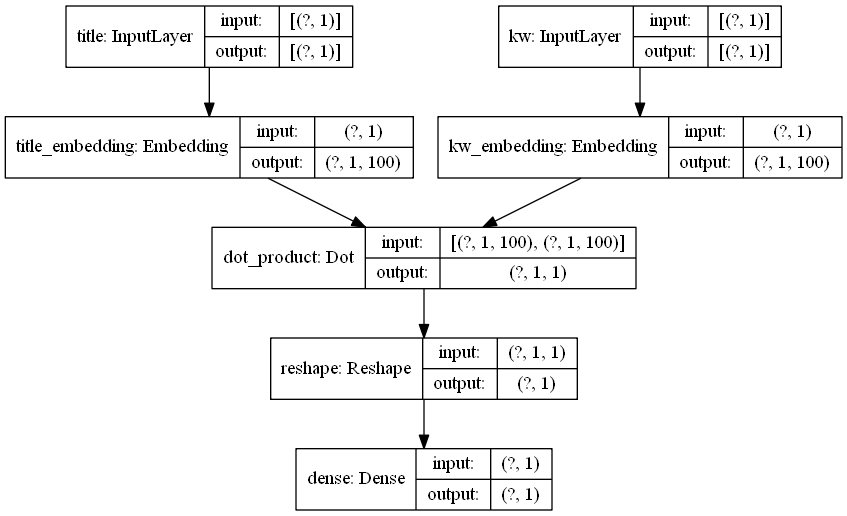

In [88]:
# Diagram of the model summary
plot_model(model, "my_first_model.png", show_shapes = True)

<span style= 'color:magenta'>Remark:</span>
The graph of how the 2 numpy array are being feed into the embedding layers and and produce 100 features of which we will use to find the determine the weights to attribute to the titles based on the keywords.

In [89]:
# Training the neural network
n_positive = 1024

gen = generate_batch(title_kw_pairs, kw_df, 'movie_id', 'kw_id', n_positive, negative_ratio = 2)

h = model.fit(gen, epochs = 50, 
                        steps_per_epoch = len(title_kw_pairs) // n_positive,
                        verbose = 2)

Epoch 1/50
38/38 - 6s - loss: 0.6900 - accuracy: 0.6565
Epoch 2/50
38/38 - 6s - loss: 0.6829 - accuracy: 0.6667
Epoch 3/50
38/38 - 6s - loss: 0.6744 - accuracy: 0.6680
Epoch 4/50
38/38 - 6s - loss: 0.6645 - accuracy: 0.6755
Epoch 5/50
38/38 - 6s - loss: 0.6539 - accuracy: 0.6932
Epoch 6/50
38/38 - 6s - loss: 0.6427 - accuracy: 0.7138
Epoch 7/50
38/38 - 6s - loss: 0.6318 - accuracy: 0.7321
Epoch 8/50
38/38 - 6s - loss: 0.6211 - accuracy: 0.7486
Epoch 9/50
38/38 - 6s - loss: 0.6110 - accuracy: 0.7588
Epoch 10/50
38/38 - 6s - loss: 0.6008 - accuracy: 0.7703
Epoch 11/50
38/38 - 6s - loss: 0.5915 - accuracy: 0.7778
Epoch 12/50
38/38 - 6s - loss: 0.5817 - accuracy: 0.7909
Epoch 13/50
38/38 - 6s - loss: 0.5732 - accuracy: 0.7965
Epoch 14/50
38/38 - 6s - loss: 0.5641 - accuracy: 0.8067
Epoch 15/50
38/38 - 6s - loss: 0.5556 - accuracy: 0.8160
Epoch 16/50
38/38 - 6s - loss: 0.5475 - accuracy: 0.8228
Epoch 17/50
38/38 - 6s - loss: 0.5400 - accuracy: 0.8305
Epoch 18/50
38/38 - 6s - loss: 0.5320 - 

#### Extracting Embeddings & Analyze

In [90]:
# Extract title embeddings for weights
title_layer = model.get_layer('title_embedding')
title_weights = title_layer.get_weights()[0]
title_weights.shape

(5198, 100)

In [91]:
# Normalizing the weights
title_weights = title_weights / np.linalg.norm(title_weights, axis = 1).reshape((-1, 1))
title_weights[0][:10]

array([ 0.11094209, -0.0559297 , -0.02004907, -0.04217826, -0.03767154,
       -0.02714065,  0.1633696 , -0.0280643 , -0.08206399,  0.05249009],
      dtype=float32)

In [92]:
# Check the standard deviation of mean
np.sum(np.square(title_weights[0]))

1.0

In [93]:
# saving NN_weights to hdf5 

with h5py.File('datasets/movie_NN.hdf5', 'w') as save_hdf5:
    save_hdf5.create_dataset("title_weights",  data=title_weights)

In [94]:
hf = h5py.File('datasets/movie_NN.hdf5','r')
print(f'Dataframe in movie_NN.hdf5 {hf.keys()}')
hf.close()

Dataframe in movie_NN.hdf5 <KeysViewHDF5 ['title_weights']>


In [95]:
hf = h5py.File('datasets/movie.hdf5','r')
print(f'Dataframe in movie.hdf5 {hf.keys()}')
hf.close()

Dataframe in movie.hdf5 <KeysViewHDF5 ['genre_series', 'idx_title_series', 'keywords_series', 'movies_sim', 'subset_title_ids', 'titles_series', 'users', 'users_sim']>
